In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
import dataset
from dataset import SKDS, TVDS, CDataset

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms


In [2]:
import numpy as np

class Dummy(CDataset):
    
    def load_data(self, boom='bust'):
        data = {1: (np.asarray([1,2,3,4]), np.asarray(100), ['apple','dog']),
                2: (np.asarray([5,6,7,8]), np.asarray(200), ['orange','cat'])}
        print(boom)
        return data
    
ds_params = {'train_params': {'embed': [('fruit',2,8,False,False),
                                        ('pet',2,8,False,False)],
                              'embed_lookup': {'fruit': {'apple': 1,
                                                         'orange': 2},
                                               'pet': {'dog': 1,
                                                       'cat': 2}},
             'boom': 'bang'}}
    
d = Dummy(**ds_params['train_params'])
d[1]           

bang
CDataset created...


(array([1, 2, 3, 4]), array(100), [tensor(1), tensor(1)])

In [ ]:
ds_params={'embed': [],
           'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = dataset.ImageDatasetStats()

for i in tvds.ds_idx:
    ids(tvds[i][0])
    
print(ids.stats.mean) #33.3
print(ids.stats.stddev) #73.7
    

In [ ]:
tvds[tvds.ds_idx[0]][0][0][100]

SKDS created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:00.651421
epoch: 0, lr: 0.01
train loss: 393216.50549768517, val loss: 45351.75078125
sk_train_log: 0, sk_val_log: 0
learning time: 0:00:07.028512
epoch: 10, lr: 0.01
train loss: 17304.38494646991, val loss: 15975.5412109375
sk_train_log: 0, sk_val_log: 0
test loss: 13289.41328125
learning time: 0:00:12.992643
test sklean metric: 
0 



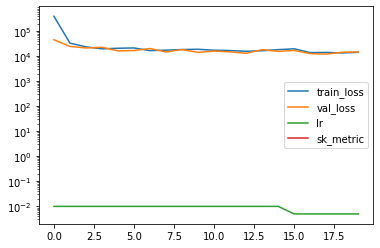

In [7]:
model_params = {'D_in': 256, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'embed': [],
                              'make': 'make_regression',
                              'transform': None,
                              'target_transform': None,
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=20)

SKDS created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:02.936619
epoch: 0, lr: 0.01
train loss: 1.3944505234777709, val loss: 1.3896626151841263
sk_train_log: 0.5019330832814533, sk_val_log: 0.5017048259764008
learning time: 0:00:14.695064
epoch: 4, lr: 0.01
train loss: 1.1183546502074915, val loss: 1.1145110068650081
sk_train_log: 0.7653184242002614, sk_val_log: 0.7706529916383662
learning time: 0:00:26.427866
epoch: 8, lr: 0.01
train loss: 0.8793491974418417, val loss: 1.022996741122213
sk_train_log: 0.8668329298800368, sk_val_log: 0.8262118195853192
test loss: 1.0194797783062375
learning time: 0:00:29.867193
test sklean metric: 
0.8257741433818878 



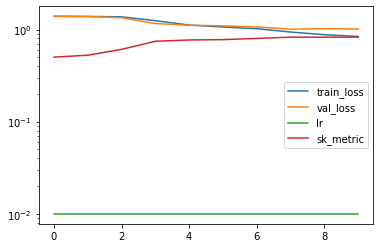

In [6]:
model_params = {'D_in': 256, 
                'H': 192, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'embed': [],
                              'make': 'make_classification',
                              'transform': transforms.Compose([dataset.AsTensor()]),
                              'target_transform': transforms.Compose(
                                                      [dataset.DType('int64'),
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()]),
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 256,
                                            'n_informative': 50,
                                            'n_clusters_per_class': 10,
                                            'flip_y': 0.05,
                                            'class_sep': 0.01,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=10)

TVDS created...
TVDS created...
TorchVision model resnet18 loaded...
learning time: 0:02:09.327261
epoch: 0, lr: 0.01
train loss: 0.274230231758828, val loss: 0.07125941069517285
sk_train_log: 0.9949304853762833, sk_val_log: 0.999535580466737
learning time: 0:04:21.692808
epoch: 1, lr: 0.01
train loss: 0.07592612649513952, val loss: 0.07747512037074193
sk_train_log: 0.9994689232558347, sk_val_log: 0.9996924513498376
learning time: 0:06:32.982187
epoch: 2, lr: 0.01
train loss: 0.05763969525045832, val loss: 0.042100675590646765
sk_train_log: 0.9996691291134377, sk_val_log: 0.9998304900295801
learning time: 0:08:44.061273
epoch: 3, lr: 0.01
train loss: 0.04890180014899427, val loss: 0.048897841061193804
sk_train_log: 0.9997533227751161, sk_val_log: 0.999737174914207
test loss: 0.031623439653359155
learning time: 0:08:51.776750
test sklean metric: 
0.9998669178244797 



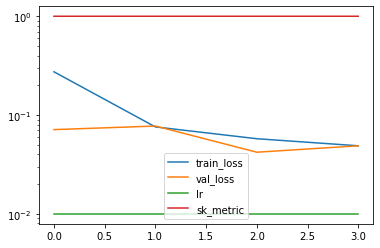

In [8]:
model_params = {'model_name': 'resnet18',
                'in_channels': 1,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'embed': [],
                            'dataset': 'MNIST',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(224),
                                                           transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'embed': [],
                           'dataset': 'MNIST',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(224),
                                                         transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.8,)}
sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=32, epochs=4)